In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import helper
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

First, load unique data points

In [2]:
train_data = helper.load_data_from_file("../data/graph_data.json") # dictionary of SMILES and values are graphs

In [3]:
# get all the unique atom types, orbitals and their respective binding energies

atoms = []
charges = []
orbs = []
energies = []


for mol in train_data:
    graph = train_data[mol]
    
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    
    for i in range(len(orb)):
        for j in range(len(orb[i])):
            if energy[i][j]!=-1:
                atoms.append(atom[i])
                charges.append(charge[i])
                orbs.append(orb[i][j])
                energies.append(energy[i][j])

Encode these data points, both atomic number and quantum numbers for orbitals

In [7]:
atom_dict = {
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
 '4p3/2': [4, 1, 1.5],
 '3d5/2': [3, 2, 2.5],
 '3d': [3, 2, 0],
 '5p3/2': [5, 1, 1.5],
 '2s': [2, 0, 0],
 '1s': [1, 0, 0],
 '4s': [4, 0, 0],
 '3p': [3, 1, 0],
 '5d5/2': [5, 2, 2.5],
 '5s': [5, 0, 0],
 '3s': [3, 0, 0],
 '3p3/2': [3, 1, 1.5],
 '4d5/2': [4, 2, 2.5],
 '4d': [4, 2, 0],
 '4f7/2': [4, 3, 3.5]
}

In [8]:
data = []

for i in range(len(atoms)):
    atom = atoms[i]
    charge = charges[i]
    orb = orbs[i]
    energy = energies[i]
    
    atomic_number = atom_dict[atom]
    q_numbers = orb_dict[orb]
    
    data.append([atomic_number]+[charge]+q_numbers+[energy])
    
data = np.array(data)

In [10]:
data

array([[4.7000e+01, 0.0000e+00, 3.0000e+00, 2.0000e+00, 2.5000e+00,
        3.7555e+02],
       [6.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.9325e+02],
       [6.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.9325e+02],
       ...,
       [3.0000e+01, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.5000e+00,
        1.0311e+03],
       [3.0000e+01, 0.0000e+00, 3.0000e+00, 1.0000e+00, 1.5000e+00,
        9.6100e+01],
       [3.0000e+01, 2.0000e+00, 3.0000e+00, 2.0000e+00, 2.5000e+00,
        1.6709e+01]])

Let us split into training and testing sets

In [11]:
data_train, data_test = train_test_split(data, train_size=0.8)
data_train = np.float_(data_train)
data_test = np.float_(data_test)

First, the training - let us split into input and output vectors

In [20]:
X_train = data_train[:,:-1]
y_train = data_train[:,-1]
y_train = y_train.reshape(-1, 1)

# z-scale
mu = np.mean(y_train)
sig = np.std(y_train)

y_train_scale = (y_train-mu)/sig

Text(0, 0.5, 'Counts')

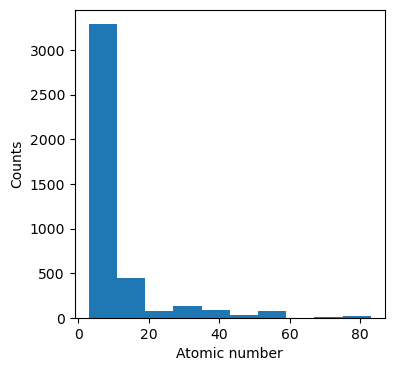

In [23]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(X_train[:,0])

ax.set_xlabel('Atomic number')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

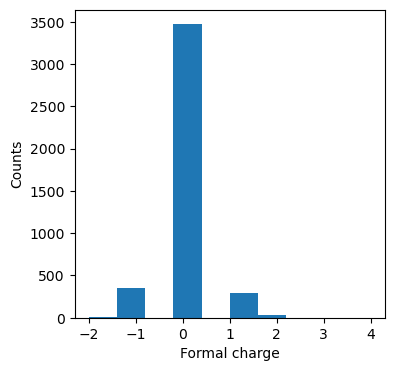

In [25]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(X_train[:,1])

ax.set_xlabel('Formal charge')
ax.set_ylabel('Counts')

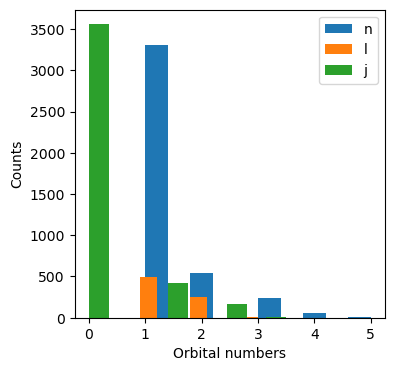

In [30]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(X_train[:,2], label='n')
ax.hist(X_train[:,3], label='l')
ax.hist(X_train[:,4], label='j')

ax.set_xlabel('Orbital numbers')
ax.set_ylabel('Counts')

ax.legend()

Text(0, 0.5, 'Counts')

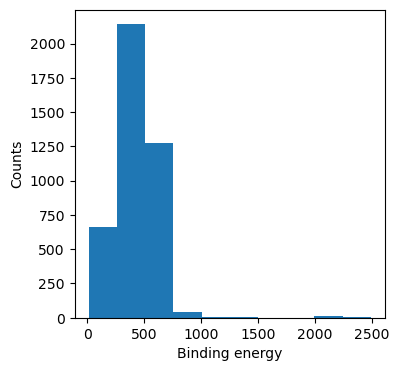

In [14]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(y_train)

ax.set_xlabel('Binding energy')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

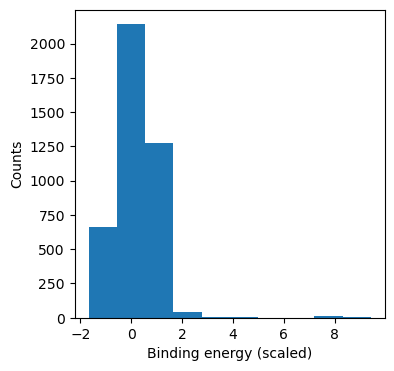

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(y_train_scale)

ax.set_xlabel('Binding energy (scaled)')
ax.set_ylabel('Counts')

In [8]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)        
        out = self.fc3(out)
        return out

In [9]:
# Model parameters
input_size = 5
hidden_size = 30
output_size = 1
batch_size = 8
learning_rate = 1e-5
num_epochs = 200

In [10]:
# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# Create a TensorDataset and DataLoader
dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Training loop
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        
        inputs = inputs.float()  # now FloatTensor
        labels = labels.float()
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    if epoch%25==0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

print("Finished Training")

Epoch 1, Loss: 1.6261
Epoch 26, Loss: 0.9726
Epoch 51, Loss: 0.9503
Epoch 76, Loss: 0.9338
Epoch 101, Loss: 0.9180
Epoch 126, Loss: 0.8967
Epoch 151, Loss: 0.8771
Epoch 176, Loss: 0.8595
Finished Training


Evaluate model predictions on test set

In [13]:
X_test = data_test[:,:-1]

In [14]:
# Minimal batch prediction approach
# Kernel dies in the simplest approach

# Set model to evaluation mode
model.eval()

# Define a reasonable batch size
batch_size = 16

# Create empty array for predictions
num_samples = X_test.shape[0]
y_pred_norm = np.zeros((num_samples, 1))

# Process in batches
for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_X = X_test[i:end_idx]
    
    # Convert to tensor, ensure float type
    batch_tensor = torch.tensor(batch_X, dtype=torch.float32)
    
    # Make prediction with no gradient tracking
    with torch.no_grad():
        y_pred_norm[i:end_idx] = model(batch_tensor).numpy()

# Convert predictions back from log10 scale
y_pred_test = sig*y_pred_norm + mu

# Get actual test values and evaluate
y_test = data_test[:, -1].reshape(-1, 1)

In [15]:
np.mean((y_test-y_pred_test)**2)

37639.05472983625